<a href="https://colab.research.google.com/github/sola-adewumi/Storm_prediction_xai/blob/main/TimeSHAP_dummy_m2_cell_wise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ==================================================================================
#   SECTION 1: Create Sequences from Data (single-location RNN model)
# ==================================================================================

### Step 1: Install Required Packages

In [ ]:
!%pip install pandas numpy
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.utils import resample
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from itertools import product
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization, SimpleRNN
from tensorflow.keras.optimizers import Adam


from itertools import product

!%pip install shap dash plotly pandas numpy scikit-learn matplotlib seaborn
import tensorflow as tf

print("TensorFlow GPU available:", len(tf.config.experimental.list_physical_devices('GPU')) > 0)


def force_detection():
    physical_devices = tf.config.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth enabled. TensorFlow is using the GPU.")
        print("TensorFlow GPU available:", True)
    else:
        print("TensorFlow GPU available:", False)

/bin/bash: line 1: fg: no job control
/bin/bash: line 1: fg: no job control
TensorFlow GPU available: True


### Step 2: Generate 90 or 180 Days of Training Data

Background Shape (BG): (5,)

Background Values (BG):
 Temp       19.384660
Press    1009.288280
Hum        74.282099
Wind       14.749692
Storm       0.000000
dtype: float64

Generated 45 sequences, each of length 2.

Sequence 1:
        Date       Temp        Press        Hum       Wind  Storm
0 2025-01-01  20.496714  1010.097078  75.625667  16.441273      0
1 2025-01-02  21.269001  1012.375910  76.253740  14.267770      0

Sequence 2:
        Date       Temp        Press        Hum       Wind  Storm
2 2025-01-03  23.434210  1012.084468  78.108889  17.556424      1
3 2025-01-04  25.633347  1013.782655  81.647948  17.065392      0

Sequence 3:
        Date       Temp        Press        Hum       Wind  Storm
4 2025-01-05  25.118152  1014.960198  82.804996  16.694644      0
5 2025-01-06  26.253631  1015.024253  85.445652  18.705987      1

Sequence 4:
        Date       Temp        Press        Hum       Wind  Storm
6 2025-01-07  29.073316  1017.790224  86.714393  18.946111      0
7 202

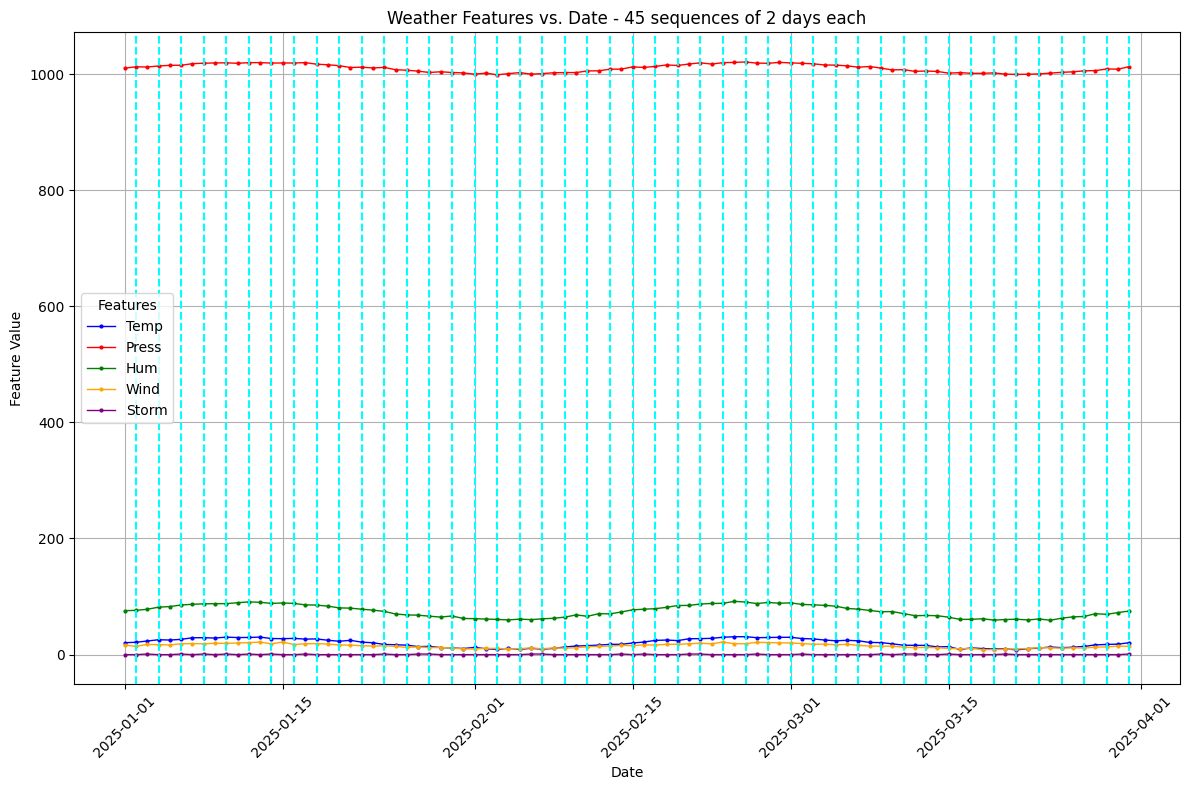

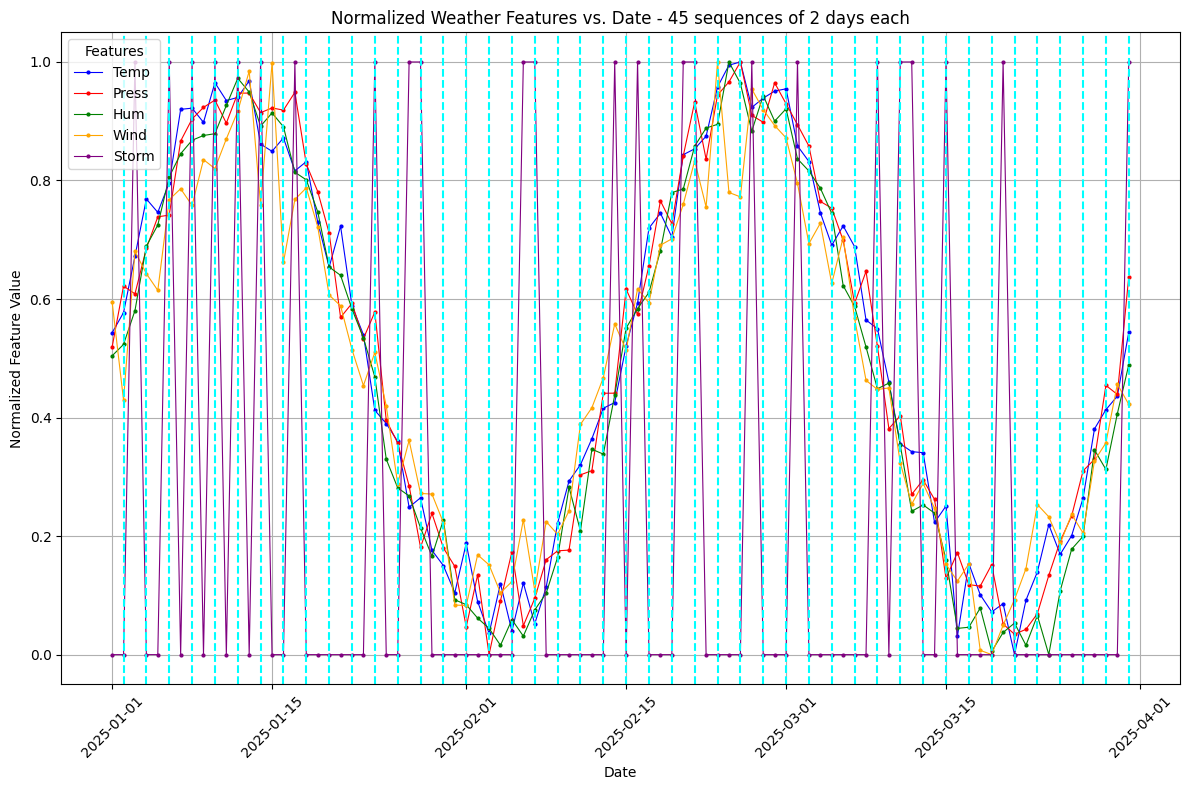

In [ ]:
# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate 90 days of daily data
num_days = 90
sequence_length = 2

# Generate sinewave data for each feature (daily averages) with noise
df_sinewave = pd.DataFrame({
    "Date": pd.date_range(start="2025-01-01", periods=num_days, freq="D"),
    "Temp": 20 + 10 * np.sin(np.linspace(0, 4 * np.pi, num_days)) + np.random.normal(0, 1, num_days),
    "Press": 1010 + 10 * np.sin(np.linspace(0, 4 * np.pi, num_days)) + np.random.normal(0, 1, num_days),
    "Hum": 75 + 15 * np.sin(np.linspace(0, 4 * np.pi, num_days)) + np.random.normal(0, 1, num_days),
    "Wind": 15 + 5 * np.sin(np.linspace(0, 4 * np.pi, num_days)) + np.random.normal(0, 1, num_days),
    "Storm": np.random.choice([0, 1], num_days, p=[0.85, 0.15])
})

df_sinewave['Date'] = pd.to_datetime(df_sinewave['Date'])

# Compute Background Values (Mean for Continuous, Mode for Binary Features)
features_for_background = ['Temp', 'Press', 'Hum', 'Wind', 'Storm']
background_sample = df_sinewave[features_for_background].sample(n=int(len(df_sinewave) * 0.5), random_state=42)

background_values = background_sample.drop(columns=['Storm']).mean()

# Improved conditional logic:
if background_sample['Storm'].nunique() <= 1 or len(background_sample) < 20: # Check for small sample size.
    background_values['Storm'] = np.random.choice(df_sinewave['Storm'], size=1)[0]
else:
    background_values['Storm'] = background_sample['Storm'].mode()[0]

print("Background Shape (BG):", background_values.shape)
print("\nBackground Values (BG):\n", background_values)

# Create Sequences (Modified to be independent of sequence_length)
def create_sequences(df, sequence_length):
    sequences = []
    for i in range(0, len(df) - sequence_length + 1, sequence_length):
        sequence = df.iloc[i:i + sequence_length].copy()
        sequence["Sequence_ID"] = len(sequences) + 1
        sequences.append(sequence)
    return pd.concat(sequences).reset_index(drop=True), len(sequences)

# Specify `sequence_length`, and number of sequences is auto-calculated
df_sequences, num_sequences = create_sequences(df_sinewave, sequence_length)

print(f"\nGenerated {num_sequences} sequences, each of length {sequence_length}.")

# Print out all the data in each sequence length for all the sequences, excluding the Sequence_ID column
for seq_id in range(1, num_sequences + 1):
    print(f"\nSequence {seq_id}:")
    print(df_sequences[df_sequences['Sequence_ID'] == seq_id].drop(columns=['Sequence_ID']))

# Define Features and Colors for Plotting
features = ['Temp', 'Press', 'Hum', 'Wind', 'Storm']
colors = ['blue', 'red', 'green', 'orange', 'purple']

# Function to Plot Original Data Without Coalitions
def plot_original_data(df, features, colors):
    plt.figure(figsize=(12, 8))

    for i, feature in enumerate(features):
        plt.plot(df['Date'], df[feature], marker='o', markersize=2, linestyle='-', color=colors[i], label=feature, linewidth=1)

    # Add vertical lines at the end of each sequence length
    for seq_id in range(1, num_sequences + 1):
        end_date = df[df['Sequence_ID'] == seq_id]['Date'].max()
        plt.axvline(x=end_date, color='aqua', linestyle='--')

    plt.title(f"Weather Features vs. Date - {num_sequences} sequences of {sequence_length} days each")
    plt.xlabel('Date')
    plt.ylabel('Feature Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title='Features')
    plt.tight_layout()
    plt.show()

# Function to Plot Normalized Data Without Coalitions
def plot_normalized_original_data(df, features, colors, scaler):
    df_normalized = df.copy()

    # Fit the scaler on the entire dataset
    scaler.fit(df[features])

    # Transform each feature using the fitted scaler
    df_normalized[features] = scaler.transform(df[features])

    plt.figure(figsize=(12, 8))

    for i, feature in enumerate(features):
        plt.plot(df_normalized['Date'], df_normalized[feature], marker='o', markersize=2, linestyle='-', color=colors[i], label=feature, linewidth=0.8)

    # Add vertical lines at the end of each sequence length
    for seq_id in range(1, num_sequences + 1):
        end_date = df[df['Sequence_ID'] == seq_id]['Date'].max()
        plt.axvline(x=end_date, color='aqua', linestyle='--')

    plt.title(f"Normalized Weather Features vs. Date - {num_sequences} sequences of {sequence_length} days each")
    plt.xlabel('Date')
    plt.ylabel('Normalized Feature Value')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title='Features')
    plt.tight_layout()
    plt.show()

# Plot Data
plot_original_data(df_sequences, features, colors)
plot_normalized_original_data(df_sequences, features, colors, MinMaxScaler())

### Step 3: Extract 18 number of sequences (with 5-day sequence_length per sequence) for the full 90-day dataset

# =============================================================================
#   SECTION 2: Coalitions of 2^m combinations of events(rows) or features are required to explain the original prediction for a sequence
# ============================================================================


### Step 1a: Perturbation Function : for row(event)-wise explanability

In [ ]:
def generate_perturbations(sequence, sequence_id, background_values):
    num_rows = len(sequence)
    num_coalitions = 2 ** num_rows

    perturbed_sequences = []
    print(f"Original Sequence {sequence_id}:\n", sequence)

    # Generate unique binary masks for all coalitions (2^m)
    all_masks = list(product([0, 1], repeat=num_rows))

    for coalition, mask_values in enumerate(all_masks):
        perturbed_seq = sequence.copy()
        mask = pd.Series(mask_values, index=sequence.index)

        # Apply perturbation based on the mask (0 → Replace with background, 1 → Keep original)
        rows_to_replace = sequence.index[mask == 0]

        # Replace missing values using the dataset mean
        perturbed_seq.loc[rows_to_replace, background_values.index] = background_values.values

        # Store the mask
        perturbed_seq['Mask'] = mask

        perturbed_sequences.append(perturbed_seq)
        print(f"Perturbed Sequence {sequence_id}; Coalition {coalition}:\n", perturbed_seq)

    return perturbed_sequences


# Example usage
sequence_id = 1
sequence = df_sequences[df_sequences['Sequence_ID'] == sequence_id].drop(columns=['Sequence_ID'])
perturbed_sequences = generate_perturbations(sequence, sequence_id, background_values)

Original Sequence 1:
         Date       Temp        Press        Hum       Wind  Storm
0 2025-01-01  20.496714  1010.097078  75.625667  16.441273      0
1 2025-01-02  21.269001  1012.375910  76.253740  14.267770      0
Perturbed Sequence 1; Coalition 0:
         Date      Temp       Press        Hum       Wind  Storm  Mask
0 2025-01-01  19.38466  1009.28828  74.282099  14.749692      0     0
1 2025-01-02  19.38466  1009.28828  74.282099  14.749692      0     0
Perturbed Sequence 1; Coalition 1:
         Date       Temp       Press        Hum       Wind  Storm  Mask
0 2025-01-01  19.384660  1009.28828  74.282099  14.749692      0     0
1 2025-01-02  21.269001  1012.37591  76.253740  14.267770      0     1
Perturbed Sequence 1; Coalition 2:
         Date       Temp        Press        Hum       Wind  Storm  Mask
0 2025-01-01  20.496714  1010.097078  75.625667  16.441273      0     1
1 2025-01-02  19.384660  1009.288280  74.282099  14.749692      0     0
Perturbed Sequence 1; Coalition 3

### Step 1b: Model Prediction from all the sequences :Event(row)-wise.



In [ ]:
# Normalize the data
scaler = MinMaxScaler()
df_scaled = df_sequences.copy()
df_scaled[features] = scaler.fit_transform(df_sequences[features])

# Create sequences for RNN input
X = []
y = []
for i in range(len(df_scaled) - sequence_length):
    X.append(df_scaled[features].iloc[i:i + sequence_length].values)
    y.append(df_scaled['Storm'].iloc[i + sequence_length])
X = np.array(X)
y = np.array(y)

# Split the data
split_index = int(len(X) * 0.8)
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

# Build the RNN model
model = Sequential([ Input(shape=(sequence_length, len(features))),SimpleRNN(20, activation='relu'), Dropout(0.2), Dense(1, activation='sigmoid')])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

# Function to generate event-wise perturbations (Corrected and Improved)
def generate_event_wise_perturbations(sequence, sequence_id, background_values):
    num_rows = len(sequence)
    num_coalitions = 2 ** num_rows  # Total unique coalitions

    perturbed_sequences = []
    print(f"Original Sequence {sequence_id}:\n", sequence)

    # Generate unique binary masks for all coalitions (2^m)
    all_masks = list(product([0, 1], repeat=num_rows))

    for coalition, mask_values in enumerate(all_masks):
        perturbed_seq = sequence.copy()
        mask = pd.Series(mask_values, index=sequence.index)
        # Apply perturbation based on the mask (0 → Replace with background, 1 → Keep original)
        rows_to_replace = sequence.index[mask == 0]

        # Replace missing values using the dataset mean
        perturbed_seq.loc[rows_to_replace, background_values.index] = background_values.values
        perturbed_seq.loc[rows_to_replace, 'Storm'] = int(background_values['Storm'])  # Ensure 'Storm' is binary (0 or 1)

        # Store the mask
        perturbed_seq['Mask'] = mask

        perturbed_sequences.append(perturbed_seq)
        print(f"Perturbed Sequence {sequence_id}; Coalition {coalition}:\n", perturbed_seq)

    return perturbed_sequences

# Function to make predictions (Corrected for Scaling)
def make_predictions(sequence, perturbed_sequences, model, scaler, features):
    # Ensure input to scaler.transform has column names
    original_sequence_df = pd.DataFrame(sequence[features], columns=features)

    scaled_sequence = scaler.transform(original_sequence_df).reshape(1, sequence_length, len(features))
    original_prediction = model.predict(scaled_sequence, verbose=0)[0][0]

    perturbed_predictions = []
    for perturbed_seq in perturbed_sequences:
        perturbed_seq_df = pd.DataFrame(perturbed_seq[features], columns=features)  # Keep feature names
        scaled_perturbed_seq = scaler.transform(perturbed_seq_df).reshape(1, sequence_length, len(features))
        perturbed_prediction = model.predict(scaled_perturbed_seq, verbose=0)[0][0]
        perturbed_predictions.append(perturbed_prediction)

    return original_prediction, perturbed_predictions

# Store all prediction results globally
prediction_results = []

# Generate predictions and store results
for seq_id in df_sequences['Sequence_ID'].unique():
    sequence = df_sequences[df_sequences['Sequence_ID'] == seq_id].drop(columns=['Sequence_ID'])
    perturbed_sequences = generate_event_wise_perturbations(sequence, seq_id, background_values)
    original_prediction, perturbed_predictions = make_predictions(sequence, perturbed_sequences, model, scaler, features)

    prediction_results.append({
        "seq_id": seq_id,
        "original_prediction": original_prediction,
        "perturbed_predictions": perturbed_predictions
    })

# --- Table and Plotting Functions ---

def create_prediction_table(prediction_results):
    table_data = []
    for result in prediction_results:
        seq_id = result["seq_id"]
        original_score = result["original_prediction"]
        coalition_scores = result["perturbed_predictions"]
        row = [f"Sequence {seq_id}"] + [original_score] + coalition_scores
        table_data.append(row)

    num_coalitions = len(prediction_results[0]['perturbed_predictions']) if prediction_results else 0
    columns = ["Sequence", "Original"] + [f"Coalition {i+1}" for i in range(num_coalitions)]
    df_table = pd.DataFrame(table_data, columns=columns)
    df_table = df_table.set_index("Sequence")
    print(df_table)
    return df_table

def plot_coalition_scores(prediction_results):
    for result in prediction_results:
        seq_id = result["seq_id"]
        original_score = result["original_prediction"]
        coalition_scores = result["perturbed_predictions"]

        df_plot = pd.DataFrame({
            'Coalition': range(1, len(coalition_scores) + 1),
            'Score': coalition_scores
        })

        plt.figure(figsize=(10, 5))
        ax = sns.barplot(data=df_plot, x="Coalition", y="Score")

        plt.axhline(y=original_score, color='black', linestyle='--', label="Original Score (Baseline)")

        plt.xlabel("Coalition Index")
        plt.ylabel("Prediction Score")
        plt.title(f"Coalition Perturbation Impact on Prediction Score (Sequence {seq_id})")
        plt.legend(title="Score Ranges", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()

        ax.set_ylim(0, 1)  # Set y-axis limits (0 to 1)
        plt.show()

Original Sequence 1:
         Date       Temp        Press        Hum       Wind  Storm
0 2025-01-01  20.496714  1010.097078  75.625667  16.441273      0
1 2025-01-02  21.269001  1012.375910  76.253740  14.267770      0
Perturbed Sequence 1; Coalition 0:
         Date      Temp       Press        Hum       Wind  Storm  Mask
0 2025-01-01  19.38466  1009.28828  74.282099  14.749692      0     0
1 2025-01-02  19.38466  1009.28828  74.282099  14.749692      0     0
Perturbed Sequence 1; Coalition 1:
         Date       Temp       Press        Hum       Wind  Storm  Mask
0 2025-01-01  19.384660  1009.28828  74.282099  14.749692      0     0
1 2025-01-02  21.269001  1012.37591  76.253740  14.267770      0     1
Perturbed Sequence 1; Coalition 2:
         Date       Temp        Press        Hum       Wind  Storm  Mask
0 2025-01-01  20.496714  1010.097078  75.625667  16.441273      0     1
1 2025-01-02  19.384660  1009.288280  74.282099  14.749692      0     0
Perturbed Sequence 1; Coalition 3

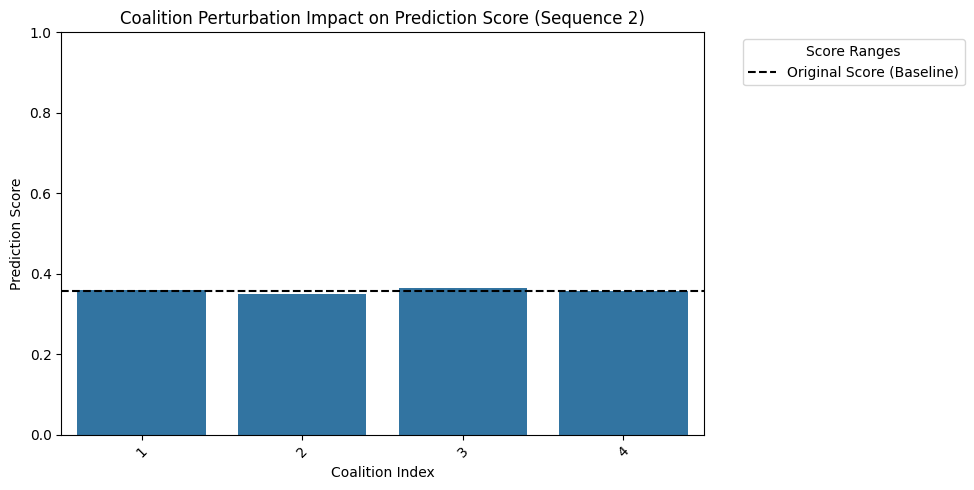

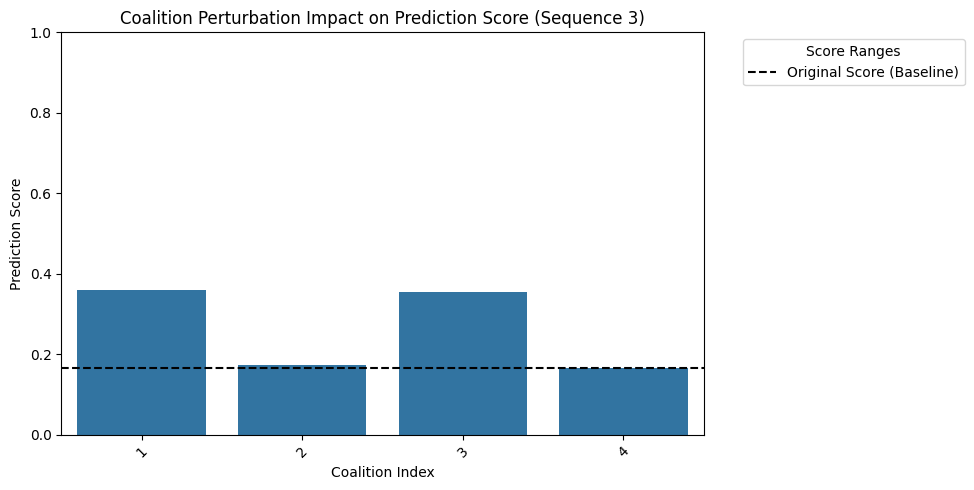

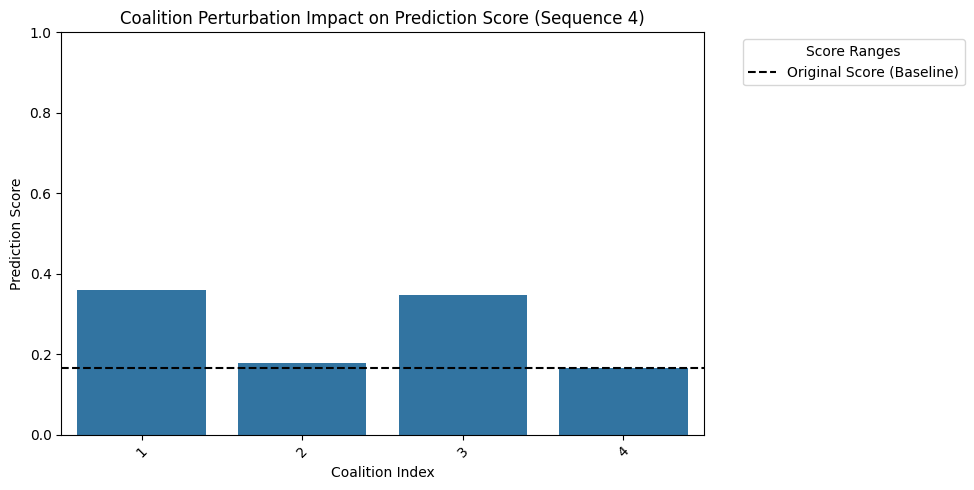

In [ ]:
# Plot all sequences after processing
plot_coalition_scores(prediction_results[1:4])

# Create and print the table
#prediction_table = create_prediction_table(prediction_results)


### Step 2a: Perturbation Function : for feature-wise explanability

In [ ]:
# Create a balanced DataFrame
df_fw = df_sequences.copy()

# Function to generate all combinations in 2^m without repeating any combination
def generate_perturbations(sequence, sequence_id, background_values):
    perturbed_sequences = []
    # Print the original sequence
    print(f"Original Sequence {sequence_id}:\n", sequence)

    # Generate all possible combinations for 2^m
    num_features = len(features)
    combinations = list(product([0, 1], repeat=num_features))

    # Iterate through each combination
    for coalition, combination in enumerate(combinations):
        perturbed_seq = sequence.copy()
        mask = pd.Series(combination, index=features)

        # Replace feature values with background values if mask value is 0
        for feature in features:
            if mask[feature] == 0:
                perturbed_seq[feature] = background_values[feature]

        # Ensure "Storm" column is integer
        perturbed_seq['Storm'] = perturbed_seq['Storm'].astype(int)

        # Add mask to the perturbed sequence
        perturbed_seq['Mask'] = ''.join(map(str, combination))
        perturbed_sequences.append(perturbed_seq)
        # Print the perturbed sequence
        print(f"Perturbed Sequence {sequence_id}; Coalition {coalition + 1}:\n", perturbed_seq)

    # Return the perturbed sequences as a single DataFrame
    return pd.concat(perturbed_sequences).reset_index(drop=True)

# Example usage of perturbation generation
sequence_id = 1
sequence = df_fw[df_sequences['Sequence_ID'] == sequence_id].drop(columns=['Sequence_ID'])
perturbed_sequences = generate_perturbations(sequence, sequence_id, background_values)

Original Sequence 1:
         Date       Temp        Press        Hum       Wind  Storm
0 2025-01-01  20.496714  1010.097078  75.625667  16.441273      0
1 2025-01-02  21.269001  1012.375910  76.253740  14.267770      0
Perturbed Sequence 1; Coalition 1:
         Date      Temp       Press        Hum       Wind  Storm   Mask
0 2025-01-01  19.38466  1009.28828  74.282099  14.749692      0  00000
1 2025-01-02  19.38466  1009.28828  74.282099  14.749692      0  00000
Perturbed Sequence 1; Coalition 2:
         Date      Temp       Press        Hum       Wind  Storm   Mask
0 2025-01-01  19.38466  1009.28828  74.282099  14.749692      0  00001
1 2025-01-02  19.38466  1009.28828  74.282099  14.749692      0  00001
Perturbed Sequence 1; Coalition 3:
         Date      Temp       Press        Hum       Wind  Storm   Mask
0 2025-01-01  19.38466  1009.28828  74.282099  16.441273      0  00010
1 2025-01-02  19.38466  1009.28828  74.282099  14.267770      0  00010
Perturbed Sequence 1; Coalition 4

### Step 2b: Model Prediction from All the Sequences: for feature-wise explanability (Fixed Sequence lenght & Sliding Windows which is more relevant to only feature-wise)


In [ ]:
features_for_explanability = ['Temp', 'Press', 'Hum', 'Wind']


df_balanced = df_sequences.copy()

# --- Feature-wise Coalitions ---
def generate_feature_wise_coalitions(sequence, background_values, features_for_explanability):
    feature_coalitions = []
    for combination in product([0, 1], repeat=len(features_for_explanability)):
        perturbed_seq = sequence.copy()
        mask = pd.DataFrame([combination] * len(sequence), columns=features_for_explanability, index=sequence.index)

        for feature in features_for_explanability:
            perturbed_seq.loc[mask[feature] == 0, feature] = background_values[feature]

        perturbed_seq['Mask'] = mask.apply(lambda row: ''.join(row.astype(int).astype(str)), axis=1)
        feature_coalitions.append(perturbed_seq)

    return feature_coalitions


# --- Data Preparation and Model Training (Sliding Window) ---
scaler_sw = MinMaxScaler()
scaler_sw.fit(df_balanced[features_for_explanability])

df_balanced_scaled_sw = df_balanced.copy()
df_balanced_scaled_sw[features_for_explanability] = scaler_sw.transform(df_balanced_scaled_sw[features_for_explanability])

X_train_sw, y_train_sw = [], []
for i in range(len(df_balanced_scaled_sw) - sequence_length + 1):
    seq_data = df_balanced_scaled_sw[features_for_explanability].iloc[i:i + sequence_length].values
    X_train_sw.append(seq_data[:-1])
    y_train_sw.append(df_balanced_scaled_sw['Storm'].iloc[i + sequence_length - 1])

X_train_sw = np.array(X_train_sw)
y_train_sw = np.array(y_train_sw)



early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Adjust patience as needed

# Optimized model
model_sw = Sequential([
    Input(shape=(sequence_length - 1, len(features_for_explanability))),
    BatchNormalization(),  # Add Batch Normalization after Input
    LSTM(64, activation='relu', return_sequences=True),  # Reduce LSTM units
    Dropout(0.3),  # Adjust dropout rate
    LSTM(32, activation='relu'),  # Reduce LSTM units
    Dropout(0.3),  # Adjust dropout rate
    BatchNormalization(),  # Add Batch Normalization before Dense layer
    Dense(1, activation='sigmoid')
])

# Use a more adaptive optimizer with a learning rate schedule
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)  # You can also use other optimizers like RMSprop

model_sw.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# changed epoch number from 50 to 100 - 14/2/2025
history_sw = model_sw.fit(X_train_sw, y_train_sw, epochs=100, batch_size=8, validation_split=0.2, callbacks=[early_stopping], verbose=0)



# --- Data Preparation and Model Training (Fixed Sequence Length) ---
scaler_seq_length = MinMaxScaler()
scaler_seq_length.fit(df_balanced[features_for_explanability])

df_balanced_scaled_seq = df_balanced.copy()
df_balanced_scaled_seq[features_for_explanability] = scaler_seq_length.transform(df_balanced_scaled_seq[features_for_explanability])

X_train_seq_length, y_train_seq_length = [], []
for i in range(0, len(df_balanced_scaled_seq) - sequence_length + 1, sequence_length):
    seq_data = df_balanced_scaled_seq[features_for_explanability].iloc[i:i + sequence_length].values
    X_train_seq_length.append(seq_data[:-1])
    y_train_seq_length.append(df_balanced_scaled_seq['Storm'].iloc[i + sequence_length - 1])

X_train_seq_length = np.array(X_train_seq_length)
y_train_seq_length = np.array(y_train_seq_length)



model_seq_length = Sequential([SimpleRNN(50, activation='relu', input_shape=(sequence_length - 1, len(features_for_explanability))),Dense(1, activation='sigmoid')])
model_seq_length.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# changed epoch number from 50 to 200 - 14/2/2025
history_seq_length = model_seq_length.fit(X_train_sw, y_train_sw, epochs=200, batch_size=4, validation_split=0.2, verbose=0)

# --- Prediction Function ---
def make_predictions(sequence, perturbed_sequences, model, scaler, features_for_explanability, sequence_length):
    sequence_df = pd.DataFrame(sequence[features_for_explanability].iloc[:-1], columns=features_for_explanability)
    scaled_sequence = scaler.transform(sequence_df)
    scaled_sequence = scaled_sequence.reshape(1, sequence_length - 1, len(features_for_explanability))

    original_prediction = model.predict(scaled_sequence, verbose=0)

    perturbed_predictions = []
    for perturbed_seq in perturbed_sequences:
        perturbed_seq_df = pd.DataFrame(perturbed_seq[features_for_explanability].iloc[:-1], columns=features_for_explanability)
        scaled_perturbed_seq = scaler.transform(perturbed_seq_df)
        scaled_perturbed_seq = scaled_perturbed_seq.reshape(1, sequence_length - 1, len(features_for_explanability))
        perturbed_prediction = model.predict(scaled_perturbed_seq, verbose=0)
        perturbed_predictions.append(perturbed_prediction)

    return original_prediction, perturbed_predictions

# --- Prediction Loop (Sliding Window) ---
def predict_sliding_window(df, model, scaler, features, sequence_length, background_values, features_for_explanability):
    prediction_results = []
    print("Sliding Window Predictions:")
    for i in range(len(df) - sequence_length + 1):
        sequence = df.iloc[i:i + sequence_length].drop(columns=['Sequence_ID', 'Storm'])
        perturbed_sequences = generate_feature_wise_coalitions(sequence.copy(), background_values, features_for_explanability)
        original_prediction, perturbed_predictions = make_predictions(sequence, perturbed_sequences, model, scaler, features_for_explanability, sequence_length)

        print(f"\nSequence Starting at Index {i} Prediction: {original_prediction[0][0]:.4f}")
        for j, perturbed_prediction in enumerate(perturbed_predictions):
            print(f"Feature-Wise Coalition {j + 1} Prediction: {perturbed_prediction[0][0]:.4f}")

        prediction_results.append({
            "seq_id": i + 1,
            "original_prediction": original_prediction[0][0],
            "perturbed_predictions": [p[0][0] for p in perturbed_predictions]
        })
    return prediction_results

# --- Prediction Loop (Fixed Sequence Length) ---
def predict_fixed_sequence_length(df, model, scaler, features, sequence_length, background_values, features_for_explanability):
    prediction_results = []
    print("\nFixed Sequence Length Predictions:")
    for i in range(0, len(df) - sequence_length + 1, sequence_length):
        sequence = df.iloc[i:i + sequence_length].drop(columns=['Sequence_ID', 'Storm'])
        perturbed_sequences = generate_feature_wise_coalitions(sequence.copy(), background_values, features_for_explanability)
        original_prediction, perturbed_predictions = make_predictions(sequence, perturbed_sequences, model, scaler, features_for_explanability, sequence_length)
        print(f"\nSequence Starting at Index {i} Prediction: {original_prediction[0][0]:.4f}")
        for j, perturbed_prediction in enumerate(perturbed_predictions):
            print(f"Feature-Wise Coalition {j + 1} Prediction: {perturbed_prediction[0][0]:.4f}")

        prediction_results.append({
            "seq_id": i // sequence_length +1,
            "original_prediction": original_prediction[0][0],
            "perturbed_predictions": [p[0][0] for p in perturbed_predictions]
        })
    return prediction_results


# --- Call Prediction Function ---
prediction_results_sliding = predict_sliding_window(df_balanced, model_sw, scaler_sw, features, sequence_length, background_values, features_for_explanability) # Added features_for_explanability
prediction_results_fixed = predict_fixed_sequence_length(df_balanced, model_seq_length, scaler_seq_length, features, sequence_length, background_values, features_for_explanability) # Added features_for_explanability

# --- Plotting Coalition Scores (Fixed Sequence Length and Sliding Window) ---
def plot_coalition_scores(prediction_results, model_name):
    for result in prediction_results:
        seq_id = result["seq_id"]
        original_score = result["original_prediction"]
        coalition_scores = result["perturbed_predictions"]

        df_plot = pd.DataFrame({'Coalition': range(1, len(coalition_scores) + 1), 'Score': coalition_scores})

        plt.figure(figsize=(10, 5))
        ax = sns.barplot(data=df_plot, x="Coalition", y="Score")

        plt.axhline(y=original_score, color='black', linestyle='--', label="Original Score (Baseline)")

        plt.xlabel("Coalition Index")
        plt.ylabel("Prediction Score")
        plt.title(f"{model_name} - Coalition Perturbation Impact (Sequence {seq_id})")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        ax.set_ylim(0, 1)
        plt.show()


# --- Plotting Training History ---
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Sliding Window Predictions:

Sequence Starting at Index 0 Prediction: 0.2407
Feature-Wise Coalition 1 Prediction: 0.3619
Feature-Wise Coalition 2 Prediction: 0.2114
Feature-Wise Coalition 3 Prediction: 0.4066
Feature-Wise Coalition 4 Prediction: 0.2623
Feature-Wise Coalition 5 Prediction: 0.4041
Feature-Wise Coalition 6 Prediction: 0.2241
Feature-Wise Coalition 7 Prediction: 0.4480
Feature-Wise Coalition 8 Prediction: 0.2775
Feature-Wise Coalition 9 Prediction: 0.3104
Feature-Wise Coalition 10 Prediction: 0.1824
Feature-Wise Coalition 11 Prediction: 0.3525
Feature-Wise Coalition 12 Prediction: 0.2278
Feature-Wise Coalition 13 Prediction: 0.3575
Feature-Wise Coalition 14 Prediction: 0.1943
Feature-Wise Coalition 15 Prediction: 0.3970
Feature-Wise Coalition 16 Prediction: 0.2407

Sequence Starting at Index 1 Prediction: 0.5844
Feature-Wise Coalition 1 Prediction: 0.3619
Feature-Wise Coalition 2 Prediction: 0.3849
Feature-Wise Coalition 3 Prediction: 0.4273
Feature-Wise Coalition 4 Predic


Fixed Sequence Length Predictions:

Sequence Starting at Index 0 Prediction: 0.2593
Feature-Wise Coalition 1 Prediction: 0.2925
Feature-Wise Coalition 2 Prediction: 0.2459
Feature-Wise Coalition 3 Prediction: 0.2958
Feature-Wise Coalition 4 Prediction: 0.2490
Feature-Wise Coalition 5 Prediction: 0.3069
Feature-Wise Coalition 6 Prediction: 0.2588
Feature-Wise Coalition 7 Prediction: 0.3103
Feature-Wise Coalition 8 Prediction: 0.2620
Feature-Wise Coalition 9 Prediction: 0.2896
Feature-Wise Coalition 10 Prediction: 0.2434
Feature-Wise Coalition 11 Prediction: 0.2930
Feature-Wise Coalition 12 Prediction: 0.2464
Feature-Wise Coalition 13 Prediction: 0.3040
Feature-Wise Coalition 14 Prediction: 0.2562
Feature-Wise Coalition 15 Prediction: 0.3074
Feature-Wise Coalition 16 Prediction: 0.2593

Sequence Starting at Index 2 Prediction: 0.2605
Feature-Wise Coalition 1 Prediction: 0.2925
Feature-Wise Coalition 2 Prediction: 0.2181
Feature-Wise Coalition 3 Prediction: 0.3023
Feature-Wise Coalition 

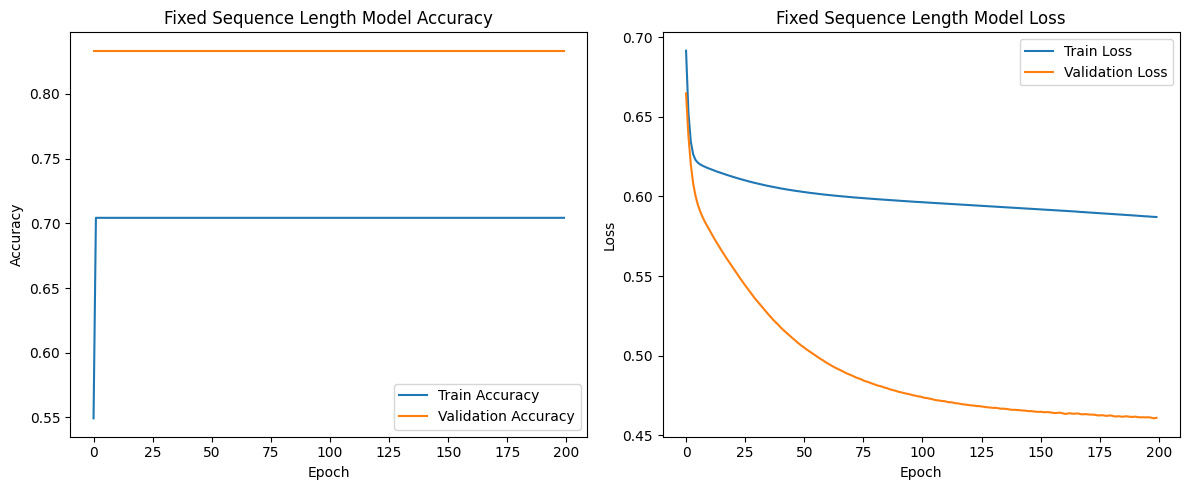

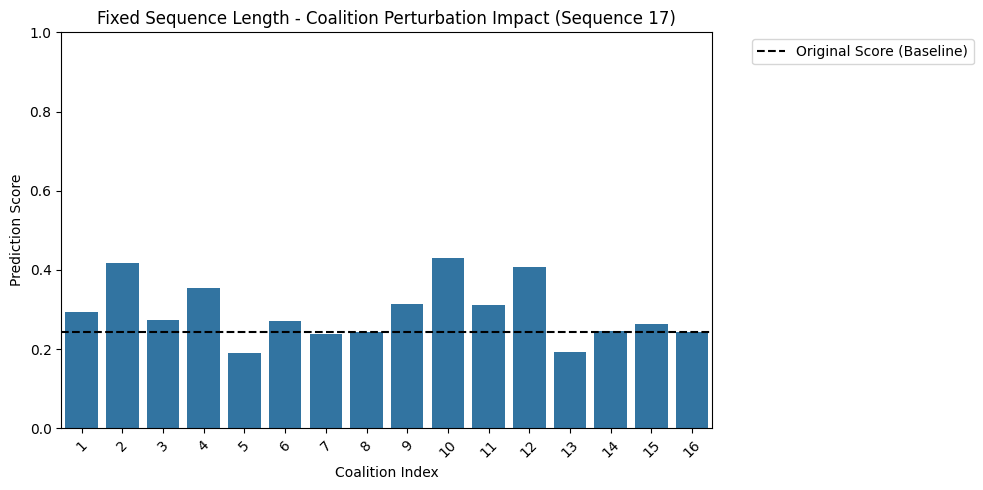

In [ ]:
## --- Call Prediction Functions for Fixed Sequence Length ---
prediction_results_fixed = predict_fixed_sequence_length(df_balanced, model_seq_length, scaler_seq_length, features, sequence_length, background_values, features_for_explanability)

plot_training_history(history_seq_length, "Fixed Sequence Length Model")

# **Select a specific sequence to plot (e.g., the first sequence)**
selected_sequence_fixed = prediction_results_fixed[16]
plot_coalition_scores([selected_sequence_fixed], "Fixed Sequence Length")


In [ ]:
## --- Call Prediction Functions for Sliding Window ---
prediction_results_sliding = predict_sliding_window(df_balanced, model_sw, scaler_sw, features, sequence_length, background_values, features_for_explanability)

plot_training_history(history_sw, "Sliding Window Model")

# **Select a specific sequence to plot (e.g., the first sequence)**
selected_sequence_sliding = prediction_results_sliding[2]
plot_coalition_scores([selected_sequence_sliding], "Sliding Window")

NameError: name 'predict_sliding_window' is not defined

# =============================================================================
#   SECTION 3: Feature Importance
# ============================================================================



Sliding Window Feature Importances: {'Temp': 0.04999999999999999, 'Press': 0.3999999999999999, 'Hum': 0.29999999999999993, 'Wind': 0.25}


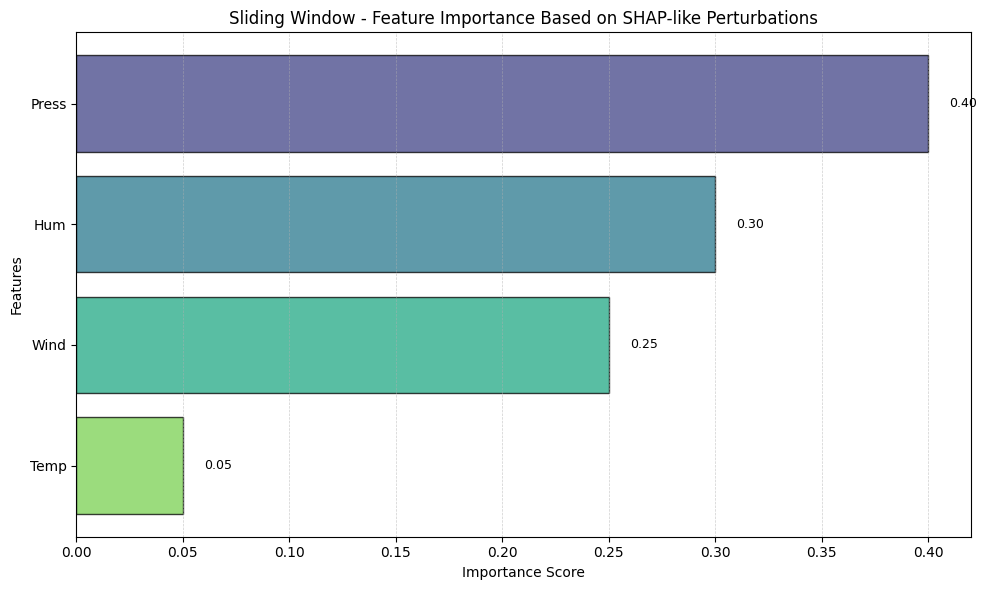


Fixed Sequence Length Feature Importances: {'Temp': 0.04999999999999998, 'Press': 0.39999999999999986, 'Hum': 0.3000000000000001, 'Wind': 0.25}


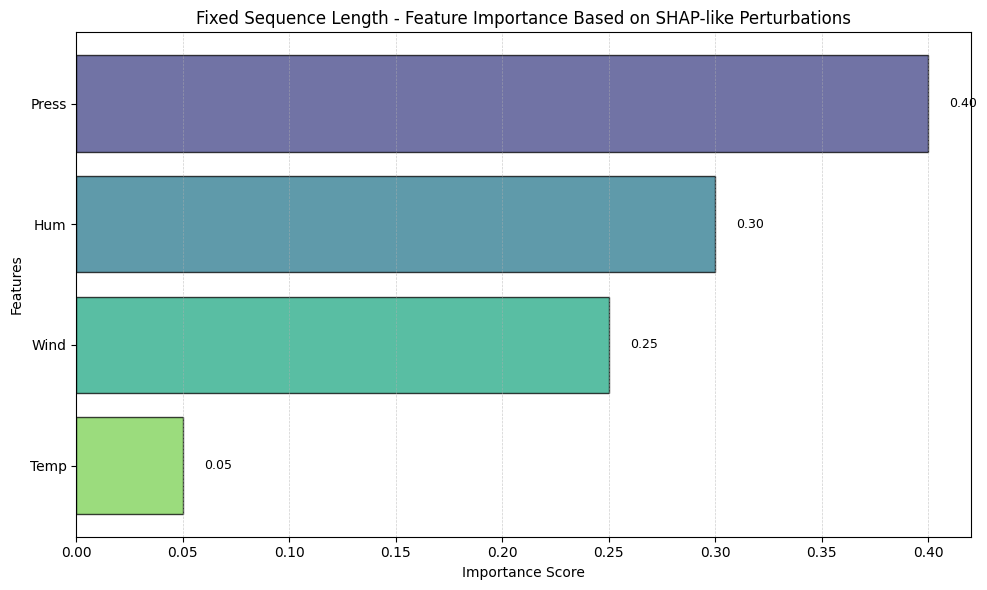

In [ ]:
# **Improved Feature Importance Calculation**
def calculate_feature_importance(perturbed_sequences, original_prediction, features_for_explanability):
    feature_importances = {feature: 0 for feature in features_for_explanability}

    for perturbed_seq in perturbed_sequences:
        mask_str = ''.join(map(str, perturbed_seq['Mask'].astype(int)))

        # Ensure correct length matching
        min_length = min(len(mask_str), len(features_for_explanability))

        for k in range(min_length):  # Prevent out of range errors
            if mask_str[k] == '0':  # Feature was perturbed
                feature_importances[features_for_explanability[k]] += abs(original_prediction - perturbed_seq['Storm'].iloc[-1])

    # Normalize feature importances (avoid division by zero)
    total_importance = sum(feature_importances.values())
    if total_importance > 0:
        feature_importances = {feature: imp / total_importance for feature, imp in feature_importances.items()}

    return feature_importances

# **Improved Feature Importance Plot with SHAP-like Style**
def plot_feature_importance(importances, model_name, features_for_explanability):
    plt.figure(figsize=(10, 6))

    #  **Sort features by importance**
    sorted_features = sorted(importances.keys(), key=lambda x: importances[x], reverse=True)
    sorted_values = [importances[feature] for feature in sorted_features]

    #  **Use consistent color mapping**
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_features)))

    plt.barh(sorted_features, sorted_values, color=colors, edgecolor='black', alpha=0.75)
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.title(f"{model_name} - Feature Importance Based on SHAP-like Perturbations")
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.6)

    #  **Display importance values on bars**
    for i, v in enumerate(sorted_values):
        plt.text(v + 0.01, i, f"{v:.2f}", va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# **Feature Importance Calculation for Sliding Window**
sliding_window_importances = {}
for i in range(len(df_balanced) - sequence_length + 1):
    sequence = df_balanced.iloc[i:i + sequence_length].drop(columns=['Sequence_ID'])
    perturbed_sequences = generate_feature_wise_coalitions(sequence.copy(), background_values, features_for_explanability)

    # **Separate original sequence for prediction**
    sequence_for_prediction = sequence.drop(columns=['Storm'])
    perturbed_sequences_for_prediction = [seq.drop(columns=['Storm']) for seq in perturbed_sequences]

    original_prediction, _ = make_predictions(sequence_for_prediction, perturbed_sequences_for_prediction, model_sw, scaler_sw, features_for_explanability, sequence_length)
    feature_importances = calculate_feature_importance(perturbed_sequences, original_prediction, features_for_explanability)

    for feature, importance in feature_importances.items():
        sliding_window_importances.setdefault(feature, []).append(importance)

#  **Compute Mean Importances**
sliding_window_importances = {feature: np.mean(importances) for feature, importances in sliding_window_importances.items()}

print("\nSliding Window Feature Importances:", sliding_window_importances)
plot_feature_importance(sliding_window_importances, "Sliding Window", features_for_explanability)

#  **Feature Importance Calculation for Fixed Sequence Length**
fixed_seq_length_importances = {}
for i in range(0, len(df_balanced) - sequence_length + 1, sequence_length):
    sequence = df_balanced.iloc[i:i + sequence_length].drop(columns=['Sequence_ID'])
    perturbed_sequences = generate_feature_wise_coalitions(sequence.copy(), background_values, features_for_explanability)

    #  **Separate original sequence for prediction**
    sequence_for_prediction = sequence.drop(columns=['Storm'])
    perturbed_sequences_for_prediction = [seq.drop(columns=['Storm']) for seq in perturbed_sequences]

    original_prediction, _ = make_predictions(sequence_for_prediction, perturbed_sequences_for_prediction, model_seq_length, scaler_seq_length, features_for_explanability, sequence_length)
    feature_importances = calculate_feature_importance(perturbed_sequences, original_prediction, features_for_explanability)

    for feature, importance in feature_importances.items():
        fixed_seq_length_importances.setdefault(feature, []).append(importance)

# **Compute Mean Importances**
fixed_seq_length_importances = {feature: np.mean(importances) for feature, importances in fixed_seq_length_importances.items()}

print("\nFixed Sequence Length Feature Importances:", fixed_seq_length_importances)
plot_feature_importance(fixed_seq_length_importances, "Fixed Sequence Length", features_for_explanability)


Original Sequence 1:
       Date      Temp       Press       Hum      Wind
2025-01-01 20.496714 1010.097078 75.625667 16.441273
2025-01-02 21.269001 1012.375910 76.253740 14.267770

Original Sequence 2:
       Date      Temp       Press       Hum      Wind
2025-01-03 23.434210 1012.084468 78.108889 17.556424
2025-01-04 25.633347 1013.782655 81.647948 17.065392

Original Sequence 3:
       Date      Temp       Press       Hum      Wind
2025-01-05 25.118152 1014.960198 82.804996 16.694644
2025-01-06 26.253631 1015.024253 85.445652 18.705987


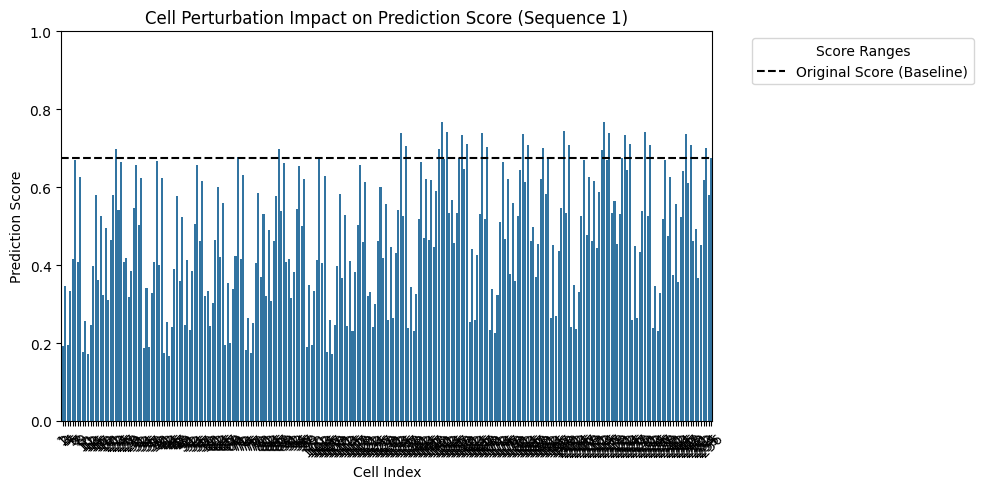

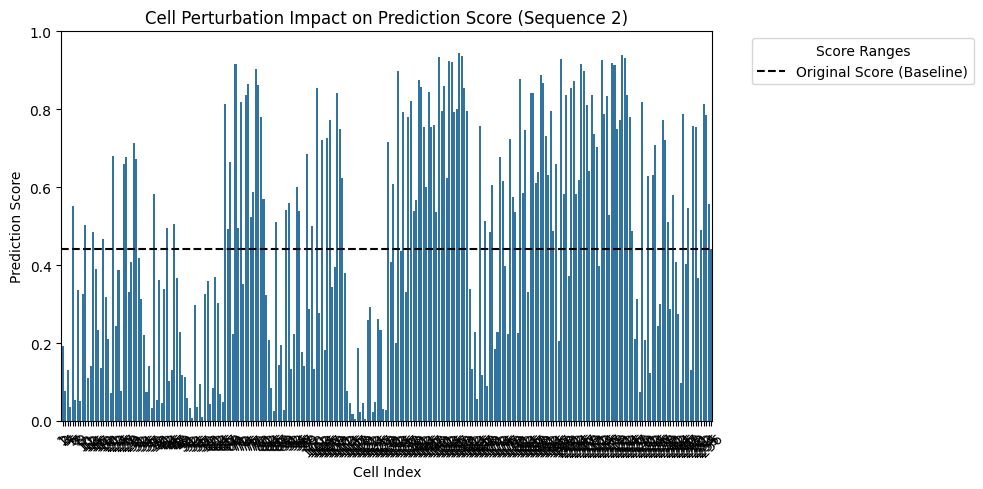

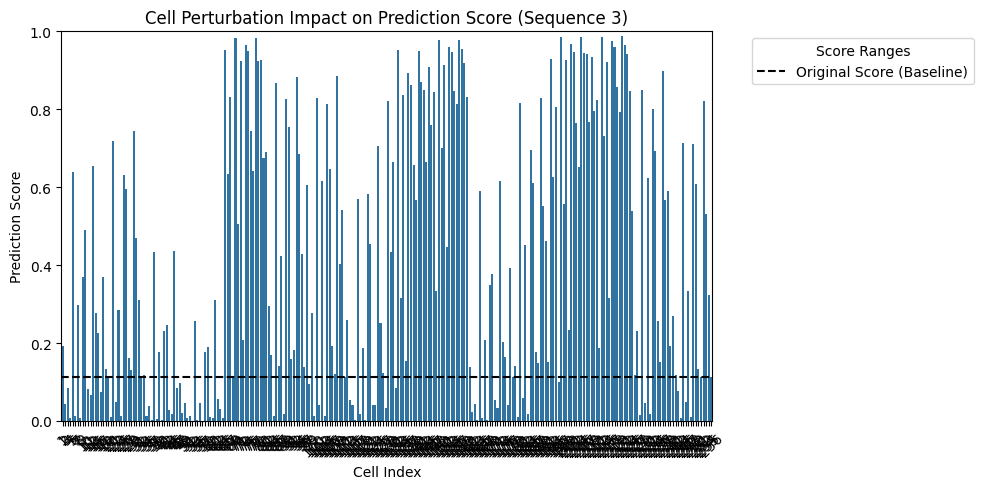

In [ ]:
# ==================================================================================
# Generate Cell-wise Perturbations
# ==================================================================================

def generate_cell_wise_perturbations(sequence, sequence_id, background_values, features_for_explanability):
    """Generates all cell-wise perturbations for a given sequence."""

    num_rows = len(sequence)
    num_features = len(features_for_explanability)
    perturbed_sequences = []

    print(f"\nOriginal Sequence {sequence_id}:\n", sequence.to_string(index=False))

    # Generate unique binary masks for all cells (2^(num_rows * num_features))
    all_masks = list(product([0, 1], repeat=num_rows * num_features))

    for coalition, mask_values in enumerate(all_masks):
        perturbed_seq = sequence.copy()

        # Reshape mask_values into a DataFrame matching the sequence shape
        mask_df = pd.DataFrame(np.array(mask_values).reshape(num_rows, num_features), columns=features_for_explanability, index=sequence.index)

        # Apply perturbations (0 → Replace with background value)
        for row_index in sequence.index:
            for feature in features_for_explanability:
                if mask_df.loc[row_index, feature] == 0:
                    perturbed_seq.loc[row_index, feature] = background_values[feature]

        # Store the mask as a string representation per row
        perturbed_seq['Mask'] = mask_df.apply(lambda row: ''.join(row.astype(str)), axis=1)

        perturbed_sequences.append(perturbed_seq)

    return perturbed_sequences

# ==================================================================================
#  Make Predictions for Cell-Wise Perturbations
# ==================================================================================

def make_predictions(sequence, perturbed_sequences, model, scaler, features_for_explanability, sequence_length):
    """Makes predictions for original and perturbed sequences."""

    sequence_df = sequence[features_for_explanability].reset_index(drop=True)


    scaled_sequence = scaler.transform(sequence_df).reshape(1, sequence_length, len(features_for_explanability))
    original_prediction = model.predict(scaled_sequence, verbose=0)[0][0]

    perturbed_predictions = []
    for perturbed_seq in perturbed_sequences:
        perturbed_seq_df = perturbed_seq[features_for_explanability].reset_index(drop=True)

        # Transform and reshape correctly
        scaled_perturbed_seq = scaler.transform(perturbed_seq_df).reshape(1, sequence_length, len(features_for_explanability))
        perturbed_prediction = model.predict(scaled_perturbed_seq, verbose=0)[0][0]

        perturbed_predictions.append(perturbed_prediction)

    return original_prediction, perturbed_predictions

# ==================================================================================
#  Train Model (Cell-wise)
# ==================================================================================

scaler_cell = MinMaxScaler()
scaler_cell.fit(df_sequences[features_for_explanability])
df_scaled_cell = df_sequences.copy()
df_scaled_cell[features_for_explanability] = scaler_cell.transform(df_scaled_cell[features_for_explanability])

X_train_cell, y_train_cell = [], []

for i in range(num_sequences):
    start_index = i * sequence_length
    end_index = start_index + sequence_length
    seq_data = df_scaled_cell[features_for_explanability].iloc[start_index:end_index].values
    X_train_cell.append(seq_data)  # Use full sequence for input
    y_train_cell.append(df_scaled_cell['Storm'].iloc[end_index - 1])

X_train_cell = np.array(X_train_cell)
y_train_cell = np.array(y_train_cell)

# Define LSTM model
model_cell = Sequential([
    Input(shape=(sequence_length, len(features_for_explanability))),
    BatchNormalization(),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model_cell.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_cell = model_cell.fit(X_train_cell, y_train_cell, epochs=200, batch_size=4, validation_split=0.2, verbose=0)

# Calculate background values (mean of each feature)
background_values = df_sequences[features_for_explanability].mean()

# Make predictions
prediction_results_cell = []
for seq_id in range(3):  # Run for first 3 sequences
    start_index = seq_id * sequence_length
    end_index = start_index + sequence_length
    sequence = df_sequences.iloc[start_index:end_index].drop(columns=['Sequence_ID', 'Storm'])  # ✅ FIXED COLUMN SELECTION

    perturbed_sequences = generate_cell_wise_perturbations(sequence.copy(), seq_id + 1, background_values, features_for_explanability)
    original_prediction, perturbed_predictions = make_predictions(sequence, perturbed_sequences, model_cell, scaler_cell, features_for_explanability, sequence_length)

    prediction_results_cell.append({
        "seq_id": seq_id + 1,
        "original_prediction": original_prediction,
        "perturbed_predictions": [p for p in perturbed_predictions]
    })

# Plot Results

def plot_cell_wise_scores(prediction_results):
    """Plots the impact of cell-wise perturbations on prediction scores."""

    for result in prediction_results:
        seq_id = result["seq_id"]
        original_score = result["original_prediction"]
        cell_scores = result["perturbed_predictions"]

        df_plot = pd.DataFrame({
            'Cell': range(1, len(cell_scores) + 1),
            'Score': cell_scores
        })

        plt.figure(figsize=(10, 5))
        ax = sns.barplot(data=df_plot, x="Cell", y="Score")

        plt.axhline(y=original_score, color='black', linestyle='--', label="Original Score (Baseline)")

        plt.xlabel("Cell Index")
        plt.ylabel("Prediction Score")
        plt.title(f"Cell Perturbation Impact on Prediction Score (Sequence {seq_id})")
        plt.legend(title="Score Ranges", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        ax.set_ylim(0, 1)
        plt.show()

plot_cell_wise_scores(prediction_results_cell)